# Khun Poker - 2 Jugadores

## Imports

In [ ]:
from games.kuhn.kuhn import KuhnPoker
from agents.counterfactual_regret import CounterFactualRegret
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt

from plot_utils import plot_strategy_evolution, plot_convergence_analysis

## Chequear la política aprendida

### Entrenar 10 veces

In [21]:
num_runs = 10
training_iterations = 2000
all_policies = []

print(f"Ejecutando {num_runs} sesiones de entrenamiento de {training_iterations} iteraciones cada una...")

for i in range(num_runs):
    print(f"\n--- Iniciando Ejecución {i+1}/{num_runs} ---")
    # Reinicializar el juego y los agentes para una ejecución limpia
    g = KuhnPoker(initial_player=0)  # Semilla fija para el juego para reproducibilidad
    agent_classes = [CounterFactualRegret, CounterFactualRegret]
    my_agents = {}
    g.reset()
    for agent_id, agent_name in enumerate(g.agents):
        my_agents[agent_name] = agent_classes[agent_id](
            game=g, 
            agent=agent_name, 
            seed=24  # Usar una semilla diferente para el agente en cada ejecución
        )

    # Entrenar agentes
    for agent_name in g.agents:
        my_agents[agent_name].train(training_iterations)

    # Almacenar las políticas de esta ejecución
    run_policies = {}
    for agent_name in g.agents:
        # Extraer la política final del diccionario de nodos del agente
        policy = OrderedDict(
            (n, my_agents[agent_name].node_dict[n].policy()) 
            for n in sorted(my_agents[agent_name].node_dict.keys())
        )
        print(policy)
        run_policies[agent_name] = policy
    all_policies.append(run_policies)
    print(f"Ejecución {i+1} completada. Políticas almacenadas.")

Ejecutando 10 sesiones de entrenamiento de 2000 iteraciones cada una...

--- Iniciando Ejecución 1/10 ---
OrderedDict([('0', array([0.76192755, 0.23807245])), ('0b', array([9.99275362e-01, 7.24637681e-04])), ('0p', array([0.7427235, 0.2572765])), ('0pb', array([9.99512459e-01, 4.87541136e-04])), ('1', array([0.97392347, 0.02607653])), ('1b', array([0.64451853, 0.35548147])), ('1p', array([0.99032951, 0.00967049])), ('1pb', array([0.36212438, 0.63787562])), ('2', array([0.34468351, 0.65531649])), ('2b', array([8.16993464e-04, 9.99183007e-01])), ('2p', array([8.16993464e-04, 9.99183007e-01])), ('2pb', array([0.00113684, 0.99886316]))])
OrderedDict([('0', array([0.78053604, 0.21946396])), ('0b', array([9.99257058e-01, 7.42942051e-04])), ('0p', array([0.66292256, 0.33707744])), ('0pb', array([9.99522664e-01, 4.77336370e-04])), ('1', array([0.98623088, 0.01376912])), ('1b', array([0.52596984, 0.47403016])), ('1p', array([0.96594427, 0.03405573])), ('1pb', array([0.4018972, 0.5981028])), ('2

### Comparar contra los valores teóricos

Los valores teóricos se calculan solo para los casos en los que existe un valor teórico para el Information Set. Existen casos como '2p' en el que el valor teórico es diferente según si el oponente tiene una Q o una J y por lo tanto no se puede calcular un valor teórico único.

In [22]:
def get_theoretical_values(alpha):
    """
    Devuelve los valores teóricos de las políticas para el Kuhn Poker dado un alpha.
    """
    return {
        '0': np.array([1 - alpha, alpha]),          # J: Bet alpha
        '1': np.array([1.0, 0.0]),                  # Q: Pass
        '2': np.array([max(0, 1 - 3*alpha), min(1, 3*alpha)]), # K: Bet 3*alpha (con clipping)
        '1pb': np.array([2/3-alpha, alpha+1/3]),                # Q, p-b: Fold (Pass)
        '2pb': np.array([0.0, 1.0]),                 # K, p-b: Call (Bet)
    }

In [23]:
# Calculate the average policy across all runs
average_policies = {}

for agent_name in g.agents:
    info_sets = all_policies[0][agent_name].keys()
    average_policies[agent_name] = {
        info_set: np.mean([run[agent_name][info_set] for run in all_policies], axis=0)
        for info_set in info_sets
    }

print("\n--- Verificando Políticas Promedio contra Valores Teóricos ---")
all_match = True
tolerance = 0.05

for agent_name, avg_policy in average_policies.items():
    print(f"\nVerificando Agente: {agent_name}")

    # Get alpha from the agent's policy of InfoSet '0', probability of Bet
    alpha = avg_policy['0'][1]
    print(f"  -> Alpha extraído: {alpha:.4f}")
    theoretical_policies = get_theoretical_values(alpha)

    for info_set, avg_actions in avg_policy.items():
        if info_set in theoretical_policies:
            theoretic_actions = theoretical_policies[info_set]
            if np.allclose(avg_actions, theoretic_actions, atol=tolerance):
                print(f"  InfoSet '{info_set}': OK.       Promedio: {np.round(avg_actions, 3)}, Teórico: {np.round(theoretic_actions, 3)}")
            else:
                all_match = False
                print(f"  InfoSet '{info_set}': FALLO.    Promedio: {np.round(avg_actions, 3)}, Teórico: {np.round(theoretic_actions, 3)}")

if all_match:
    print("\n¡Éxito! Todas las políticas promedio coinciden con los valores teóricos dentro de la tolerancia.")
else:
    print("\nAlgunas políticas promedio no coinciden con los valores teóricos.")


--- Verificando Políticas Promedio contra Valores Teóricos ---

Verificando Agente: agent_0
  -> Alpha extraído: 0.2054
  InfoSet '0': OK.       Promedio: [0.795 0.205], Teórico: [0.795 0.205]
  InfoSet '1': OK.       Promedio: [0.971 0.029], Teórico: [1. 0.]
  InfoSet '1pb': OK.       Promedio: [0.414 0.586], Teórico: [0.461 0.539]
  InfoSet '2': FALLO.    Promedio: [0.318 0.682], Teórico: [0.384 0.616]
  InfoSet '2pb': OK.       Promedio: [0.002 0.998], Teórico: [0. 1.]

Verificando Agente: agent_1
  -> Alpha extraído: 0.1865
  InfoSet '0': OK.       Promedio: [0.813 0.187], Teórico: [0.813 0.187]
  InfoSet '1': OK.       Promedio: [0.988 0.012], Teórico: [1. 0.]
  InfoSet '1pb': OK.       Promedio: [0.473 0.527], Teórico: [0.48 0.52]
  InfoSet '2': OK.       Promedio: [0.441 0.559], Teórico: [0.44 0.56]
  InfoSet '2pb': OK.       Promedio: [0.001 0.999], Teórico: [0. 1.]

Algunas políticas promedio no coinciden con los valores teóricos.


In [24]:
print("\n--- Verificando Cada Ejecución contra Valores Teóricos ---")
all_match = True
tolerance = 0.05

for i, run_policies in enumerate(all_policies):
    print(f"\nEjecución {i+1}:")
    for agent_name, learned_policy in run_policies.items():
        print(f"\nVerificando Agente: {agent_name}")

        # Get alpha from the agent's policy of InfoSet '0', probability of Bet
        alpha = learned_policy['0'][1]
        print(f"  -> Alpha extraído: {alpha:.4f}")
        theoretical_policies = get_theoretical_values(alpha)

        for info_set, learned_actions in learned_policy.items():
            if info_set in theoretical_policies:
                theoretic_actions = theoretical_policies[info_set]
                if np.allclose(learned_actions, theoretic_actions, atol=tolerance):
                    print(f"  InfoSet '{info_set}': OK.       Aprendido: {np.round(learned_actions, 3)}, Teórico: {np.round(theoretic_actions, 3)}")
                else:
                    all_match = False
                    print(f"  InfoSet '{info_set}': FALLO.    Aprendido: {np.round(learned_actions, 3)}, Teórico: {np.round(theoretic_actions, 3)}")

if all_match:
    print("\n¡Éxito! Todas las políticas aprendidas en cada ejecución coinciden con los valores teóricos dentro de la tolerancia.")
else:
    print("\nAlgunas políticas aprendidas en las ejecuciones no coinciden con los valores teóricos.")


--- Verificando Cada Ejecución contra Valores Teóricos ---

Ejecución 1:

Verificando Agente: agent_0
  -> Alpha extraído: 0.2381
  InfoSet '0': OK.       Aprendido: [0.762 0.238], Teórico: [0.762 0.238]
  InfoSet '1': OK.       Aprendido: [0.974 0.026], Teórico: [1. 0.]
  InfoSet '1pb': FALLO.    Aprendido: [0.362 0.638], Teórico: [0.429 0.571]
  InfoSet '2': FALLO.    Aprendido: [0.345 0.655], Teórico: [0.286 0.714]
  InfoSet '2pb': OK.       Aprendido: [0.001 0.999], Teórico: [0. 1.]

Verificando Agente: agent_1
  -> Alpha extraído: 0.2195
  InfoSet '0': OK.       Aprendido: [0.781 0.219], Teórico: [0.781 0.219]
  InfoSet '1': OK.       Aprendido: [0.986 0.014], Teórico: [1. 0.]
  InfoSet '1pb': OK.       Aprendido: [0.402 0.598], Teórico: [0.447 0.553]
  InfoSet '2': OK.       Aprendido: [0.308 0.692], Teórico: [0.342 0.658]
  InfoSet '2pb': OK.       Aprendido: [0.001 0.999], Teórico: [0. 1.]

Ejecución 2:

Verificando Agente: agent_0
  -> Alpha extraído: 0.1671
  InfoSet '0': OK

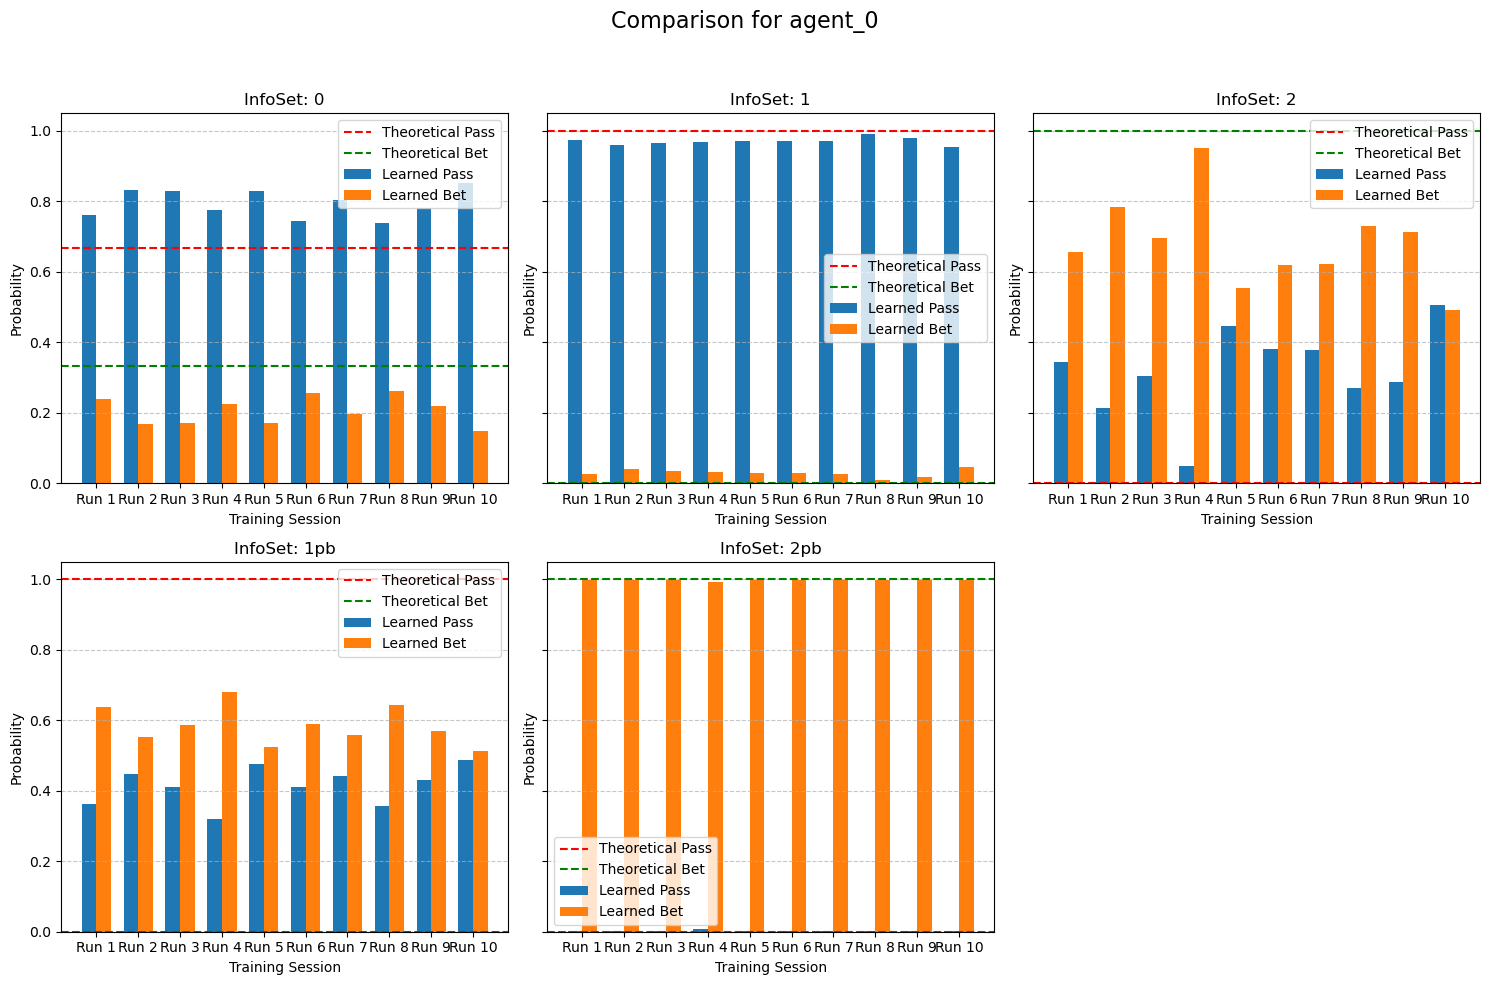

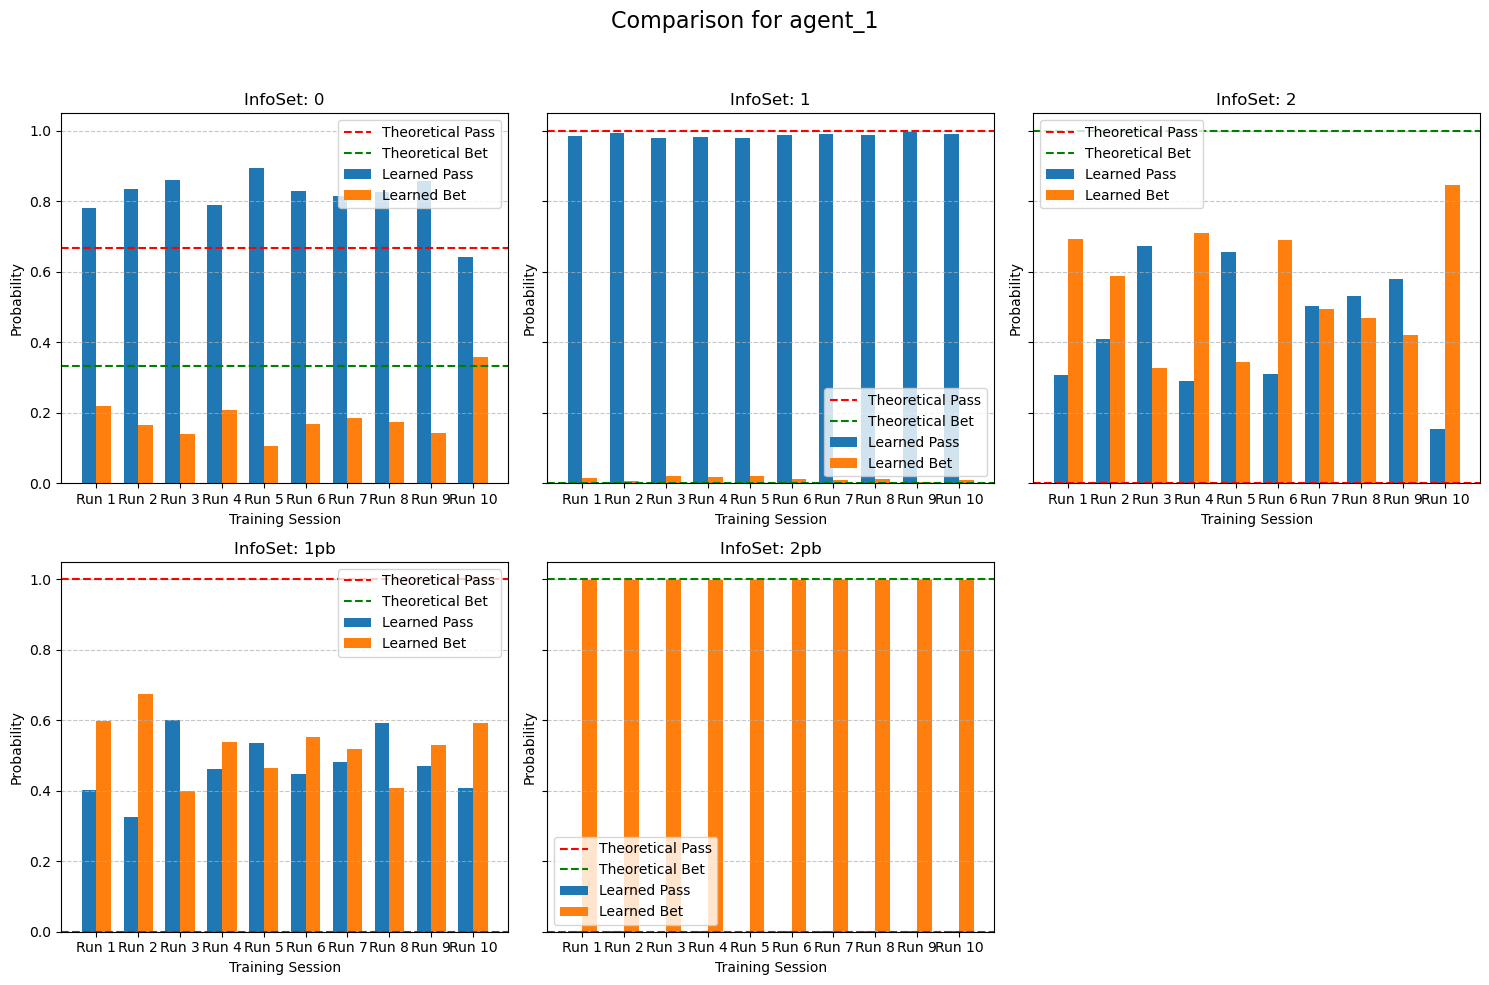

In [28]:
# Define the theoretical policies (adjust alpha dynamically if needed)
alpha = 1/3  # Replace with dynamically calculated alpha if required
theoretical_policies = {
    'agent_0': {
        '0': np.array([1 - alpha, alpha]),          # J: Bet alpha
        '1': np.array([1.0, 0.0]),                  # Q: Pass
        '2': np.array([1 - 3*alpha, 3*alpha]),      # K: Bet 3*alpha
        '1pb': np.array([1.0, 0.0]),                # Q, p-b: Fold
        '2pb': np.array([0.0, 1.0])                 # K, p-b: Call
    },
    'agent_1': {
        '0': np.array([1 - alpha, alpha]),          # J: Bet alpha
        '1': np.array([1.0, 0.0]),                  # Q: Pass
        '2': np.array([1 - 3*alpha, 3*alpha]),      # K: Bet 3*alpha
        '1pb': np.array([1.0, 0.0]),                # Q, p-b: Fold
        '2pb': np.array([0.0, 1.0])                 # K, p-b: Call
    }
}

# Create plots for each agent
for agent_name, theoretical_policy in theoretical_policies.items():
    info_sets = list(theoretical_policy.keys())
    num_info_sets = len(info_sets)
    nrows = 2
    ncols = (num_info_sets + 1) // 2  # Ensure all info sets fit into 2 rows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows), sharey=True)
    fig.suptitle(f"Comparison for {agent_name}", fontsize=16)

    # Flatten axes for easier indexing
    axes = axes.flatten()

    for idx, info_set in enumerate(info_sets):
        ax = axes[idx]
        theoretic_actions = theoretical_policy[info_set]
        learned_values = [run[agent_name][info_set] for run in all_policies if info_set in run[agent_name]]

        if not learned_values:
            ax.set_title(f"InfoSet: {info_set}")
            ax.text(0.5, 0.5, "No Data", horizontalalignment='center', verticalalignment='center', fontsize=12)
            ax.axis('off')
            continue

        x = np.arange(len(learned_values))
        width = 0.35

        # Plot learned values
        for action_idx, action_name in enumerate(['Pass', 'Bet']):
            ax.bar(x + width * action_idx, [values[action_idx] for values in learned_values], width, label=f'Learned {action_name}')

        # Plot theoretical values
        colors = ['r', 'g']
        for action_idx, action_name in enumerate(['Pass', 'Bet']):
            ax.axhline(y=theoretic_actions[action_idx], color=colors[action_idx], linestyle='--', label=f'Theoretical {action_name}')

        # Add labels and legend
        ax.set_title(f"InfoSet: {info_set}")
        ax.set_xlabel("Training Session")
        ax.set_ylabel("Probability")
        ax.set_xticks(x + width / 2)
        ax.set_xticklabels([f"Run {i+1}" for i in range(len(learned_values))])
        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Hide unused subplots
    for idx in range(len(info_sets), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

## Análisis del entrenamiento

In [ ]:
g = KuhnPoker(initial_player=0) 
agent_classes = [CounterFactualRegret, CounterFactualRegret]
my_agents = {}
g.reset()
for i, agent in enumerate(g.agents):
    my_agents[agent] = agent_classes[i](
        game=g, 
        agent=agent, 
        track_frequency=1,
        seed=42,
    )

In [ ]:
for agent in g.agents:
    print('Training agent ' + agent)
    my_agents[agent].train(10000)
    print('Agent ' + agent + ' policies:')
    print(OrderedDict(map(lambda n: (n, my_agents[agent].node_dict[n].policy()), sorted(my_agents[agent].node_dict.keys()))))
    print('')

Training agent agent_0
Agent agent_0 policies:
OrderedDict([('0', array([0.67195932, 0.32804068])), ('0b', array([9.9984985e-01, 1.5015015e-04])), ('0p', array([0.70387647, 0.29612353])), ('0pb', array([9.99889074e-01, 1.10926157e-04])), ('1', array([0.99882219, 0.00117781])), ('1b', array([0.6686779, 0.3313221])), ('1p', array([0.99725836, 0.00274164])), ('1pb', array([0.32767128, 0.67232872])), ('2', array([0.05020658, 0.94979342])), ('2b', array([1.49790294e-04, 9.99850210e-01])), ('2p', array([7.48951468e-04, 9.99251049e-01])), ('2pb', array([0.00148374, 0.99851626]))])

Training agent agent_1
Agent agent_1 policies:
OrderedDict([('0', array([0.71012186, 0.28987814])), ('0b', array([9.99850835e-01, 1.49164678e-04])), ('0p', array([0.67262358, 0.32737642])), ('0pb', array([9.99893768e-01, 1.06231820e-04])), ('1', array([0.998218, 0.001782])), ('1b', array([0.63359981, 0.36640019])), ('1p', array([0.99787106, 0.00212894])), ('1pb', array([0.30079343, 0.69920657])), ('2', array([0.030

### Evolución de la política durante el entrenamiento

**Agente 0**

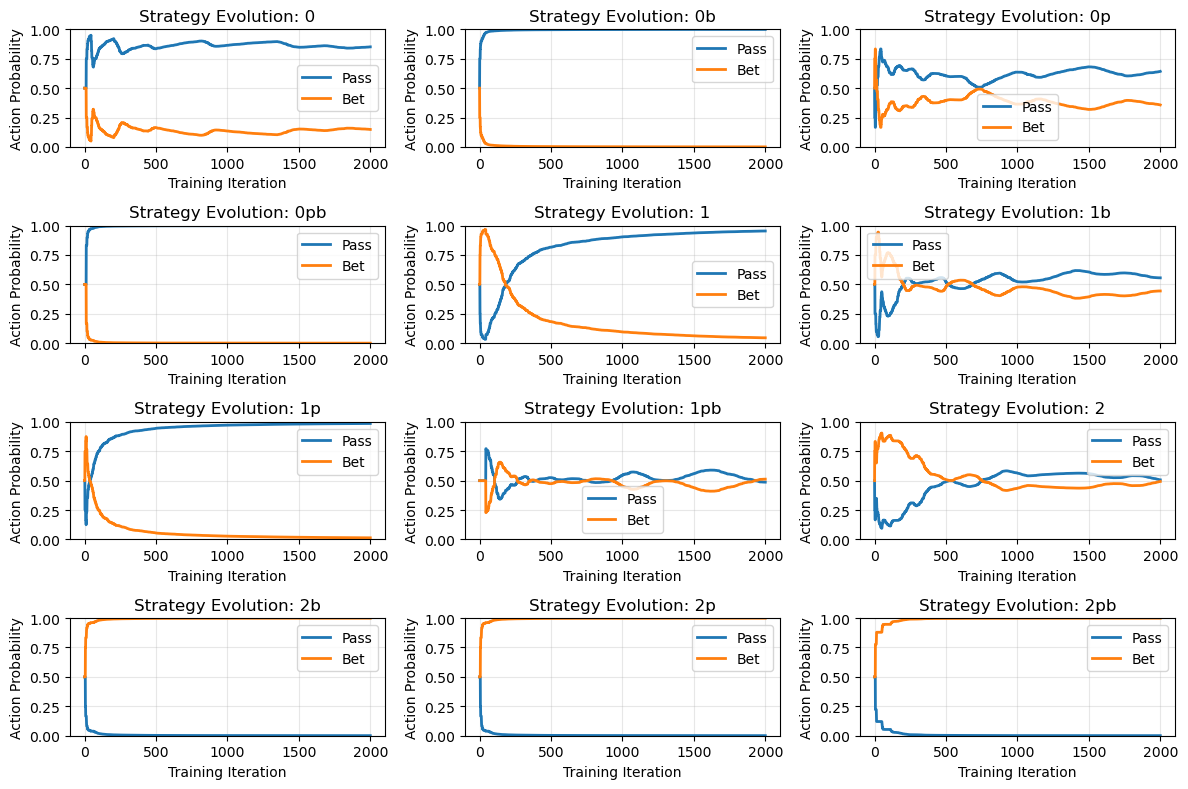

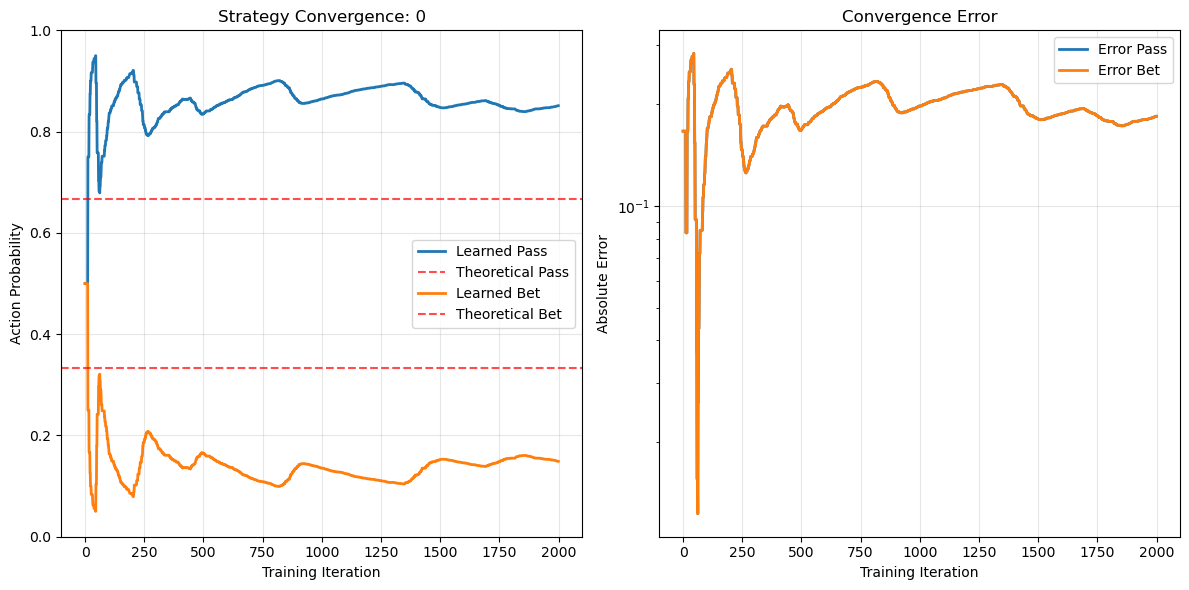

In [ ]:
theoretical_JX_bet = 1/3

strategy_history = my_agents['agent_0'].strategy_history
iteration_history = my_agents['agent_0'].iteration_history

plot_strategy_evolution(strategy_history, iteration_history, 
                        action_names={0: 'Pass', 1: 'Bet'})

plot_convergence_analysis(strategy_history, iteration_history, info_set_key='0', 
                          action_names={0: 'Pass', 1: 'Bet'}, 
                          theoretical_values={0: 1 - theoretical_JX_bet, 1: theoretical_JX_bet},
                          figsize=(12, 6))

**Agente 1**

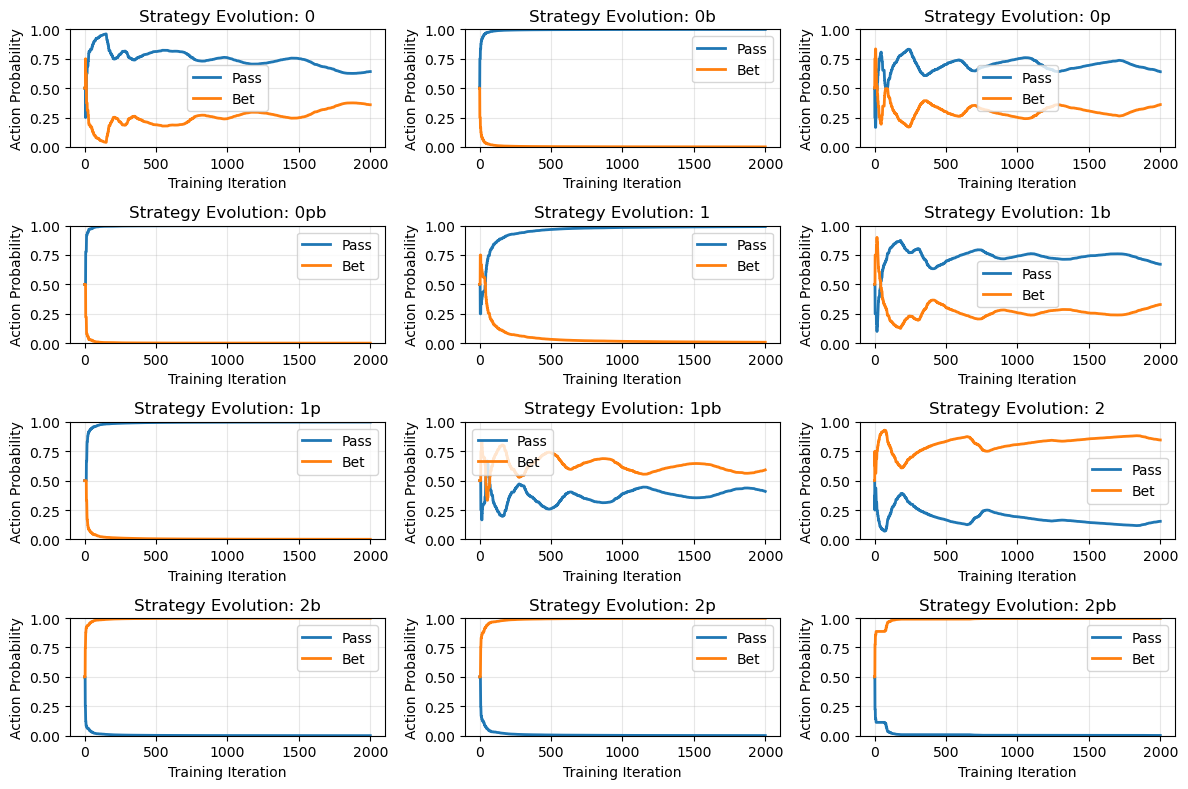

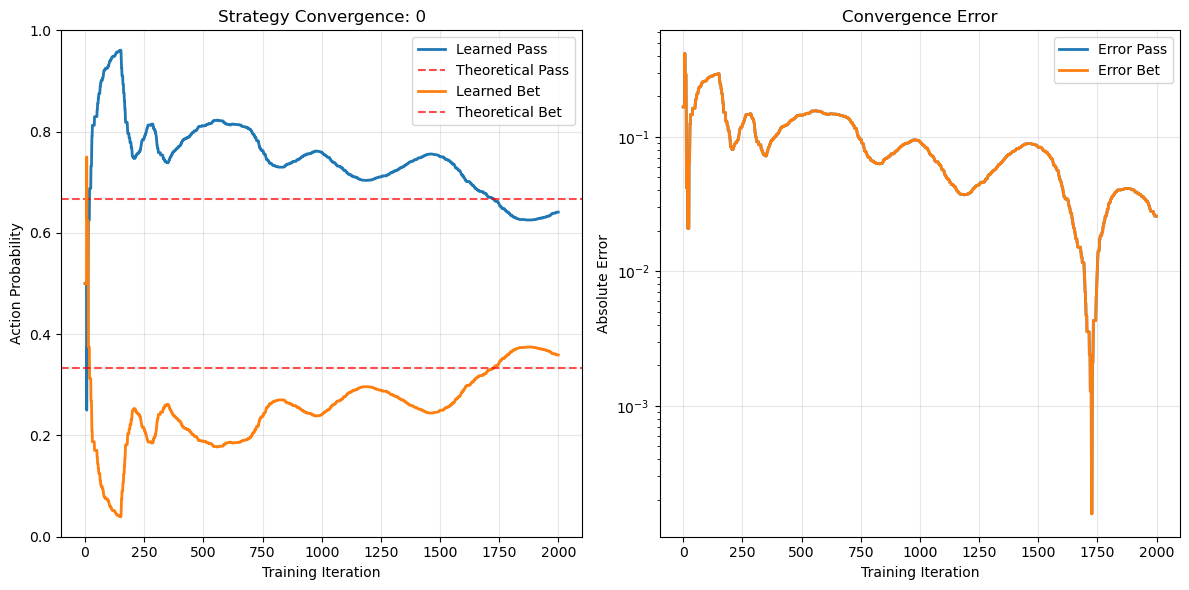

In [37]:
theoretical_JX_bet = 1/3

strategy_history = my_agents['agent_1'].strategy_history
iteration_history = my_agents['agent_1'].iteration_history

plot_strategy_evolution(strategy_history, iteration_history, 
                        action_names={0: 'Pass', 1: 'Bet'})

plot_convergence_analysis(strategy_history, iteration_history, info_set_key='0', 
                          action_names={0: 'Pass', 1: 'Bet'}, 
                          theoretical_values={0: 1 - theoretical_JX_bet, 1: theoretical_JX_bet},
                          figsize=(12, 6))

### Ejecutar partidas CFR vs CFR

In [ ]:
cum_rewards = dict(map(lambda agent: (agent, 0.), g.agents))
niter = 20000
for _ in range(niter):
    g.reset()
    turn = 0
    while not g.done():
        # print('Turn: ', turn)
        # print('\tPlayer: ', g.agent_selection)
        # print('\tObservation: ', g.observe(g.agent_selection))
        a = my_agents[g.agent_selection].action()
        # print('\tAction: ', g._moves[a])
        g.step(action=a)
        turn += 1
    #print('Rewards: ', g.rewards)
    for agent in g.agents:
        cum_rewards[agent] += g.rewards[agent]
print('Average rewards:', dict(map(lambda agent: (agent, cum_rewards[agent]/niter), g.agents)))
print('Teoretical rewards: ', {g.agents[0]: np.round(-1/18, 3), g.agents[1]: np.round(1/18, 3)})


Average rewards: {'agent_0': -0.0357, 'agent_1': 0.0357}
Teoretical rewards:  {'agent_0': np.float64(-0.056), 'agent_1': np.float64(0.056)}
